## BDA Group Members 
- Goud, Kyra 
- Stein, Varvara
- Tan, Xiao
- Odoni, Reto
- Ongkingco, Calvin Mitchell 

## Data Collection and Background

The twitter data for the sentiment analysis is from Panacea Lab at Georgia State University. It consists of separated daily data from 2020-03-22 until 2021-06-05 (now). They state it as “Covid-19 Twitter chatter dataset for scientific use” and provided the corresponding tweet identifiers which in a next step need to be hydrated to be used. This is due to the terms and conditions of Twitter to re-distribute Twitter data. Therefore we created a Twitter developer account and then could follow the neat tutorial Juan M. Banda et al. provided to hydrate the data. Mainly it consists of two parts, the script configuration and the downloading of the tweets itself. We specified that we only wanted to use the english data and then left the computer downloading the tweets for the different days we had chosen.

The aim of the project is to explore the data related to coronavirus at different periods of time and to analyse the general trends in users’ attitude (negative, neutral, positive). Additionally we would like to inspect whether the word ‘mask’ evoked positive or negative emotions over time. 

We expect the date of tweets to correlate with the rate of positive, neutral, and negative scores. For instance, neutral tweets may prevail in the most recent dataset, whereas the earliest dataset may have the biggest amount of negative tweets. The same pattern would apply to the word ‘mask’.


### Data Collection Functions

In [ ]:
import json
import tweepy
from tweepy import OAuthHandler

# Authenticate
CONSUMER_KEY = "" #@param {type:"string"}
CONSUMER_SECRET_KEY = "" #@param {type:"string"}
ACCESS_TOKEN_KEY = "" #@param {type:"string"}
ACCESS_TOKEN_SECRET_KEY = "" #@param {type:"string"}

#Creates a JSON Files with the API credentials
with open('api_keys.json', 'w') as outfile:
    json.dump({
    "consumer_key":CONSUMER_KEY,
    "consumer_secret":CONSUMER_SECRET_KEY,
    "access_token":ACCESS_TOKEN_KEY,
    "access_token_secret": ACCESS_TOKEN_SECRET_KEY
     }, outfile)

#The lines below are just to test if the twitter credentials are correct
# Authenticate
#auth = tweepy.AppAuthHandler(CONSUMER_KEY, CONSUMER_SECRET_KEY)

#api = tweepy.API(auth, wait_on_rate_limit=True,
#				   wait_on_rate_limit_notify=True)

#if (not api):
#    print ("Can't Authenticate")
#    sys.exit(-1)


In [ ]:
import gzip
import shutil
import os
import wget
import csv
import linecache
from shutil import copyfile
import ipywidgets as widgets
import numpy as np
import pandas as pd

dataset_URL = "https://github.com/thepanacealab/covid19_twitter/blob/master/dailies/2021-06-05/2021-06-05_clean-dataset.tsv.gz?raw=true" #@param {type:"string"}

#Downloads the dataset (compressed in a GZ format)
#!wget dataset_URL -O clean-dataset.tsv.gz
wget.download(dataset_URL, out='clean-dataset.tsv.gz')

#Unzips the dataset and gets the TSV dataset
with gzip.open('clean-dataset.tsv.gz', 'rb') as f_in:
    with open('clean-dataset.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

#Deletes the compressed GZ file
os.unlink("clean-dataset.tsv.gz")

#Gets all possible languages from the dataset
df = pd.read_csv('clean-dataset.tsv',sep="\t")
lang_list = df.lang.unique()
lang_list= sorted(np.append(lang_list,'all'))
lang_picker = widgets.Dropdown(options=lang_list, value="en")
lang_picker


#Creates a new clean dataset with the specified language (if specified)
filtered_language = lang_picker.value

#If no language specified, it will get all records from the dataset
if filtered_language == "":
    copyfile('clean-dataset.tsv', 'clean-dataset-filtered.tsv')

#If language specified, it will create another tsv file with the filtered records
else:
    filtered_tw = list()
    current_line = 1
    with open("clean-dataset.tsv") as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter="\t")
    if current_line == 1:
        filtered_tw.append(linecache.getline("clean-dataset.tsv", current_line))

        for line in tsvreader:
            if line[3] == filtered_language:
                filtered_tw.append(linecache.getline("clean-dataset.tsv", current_line))
            current_line += 1

print('\033[1mShowing first 5 tweets from the filtered dataset\033[0m')
print(filtered_tw[1:(6 if len(filtered_tw) > 6 else len(filtered_tw))])

  with open('clean-dataset-filtered.tsv', 'w') as f_output:
        for item in filtered_tw:
            f_output.write(item)

In [ ]:
# Developed during Biomedical Hackathon 6 - http://blah6.linkedannotation.org/
# Authors: Ramya Tekumalla, Javad Asl, Juan M. Banda
# Contributors: Kevin B. Cohen, Joanthan Lucero

import tweepy
import json
import math
import glob
import csv
import zipfile
import zlib
import argparse
import os
import os.path as osp
import pandas as pd
from tweepy import TweepError
from time import sleep


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("-o", "--outputfile", help="Output file name with extension")
    parser.add_argument("-i", "--inputfile", help="Input file name with extension")
    parser.add_argument("-k", "--keyfile", help="Json api key file name")
    parser.add_argument("-c", "--idcolumn", help="tweet id column in the input file, string name")
    parser.add_argument("-m", "--mode", help="Enter e for extended mode ; else the program would consider default compatible mode")


    args = parser.parse_args()
    if args.inputfile is None or args.outputfile is None:
        parser.error("please add necessary arguments")
        
    if args.keyfile is None:
        parser.error("please add a keyfile argument")

    with open(args.keyfile) as f:
        keys = json.load(f)

    auth = tweepy.OAuthHandler(keys['consumer_key'], keys['consumer_secret'])
    auth.set_access_token(keys['access_token'], keys['access_token_secret'])
    api = tweepy.API(auth, wait_on_rate_limit=True, retry_delay=60*3, retry_count=5,retry_errors=set([401, 404, 500, 503]), wait_on_rate_limit_notify=True)
    
    if api.verify_credentials() == False: 
        print("Your twitter api credentials are invalid") 
        sys.exit()
    else: 
        print("Your twitter api credentials are valid.") 
    
    
    output_file = args.outputfile
    hydration_mode = args.mode

    output_file_noformat = output_file.split(".",maxsplit=1)[0]
    print(output_file)
    output_file = '{}'.format(output_file)
    output_file_short = '{}_short.json'.format(output_file_noformat)
    compression = zipfile.ZIP_DEFLATED    
    ids = []
    
    if '.tsv' in args.inputfile:
        inputfile_data = pd.read_csv(args.inputfile, sep='\t')
        print('tab seperated file, using \\t delimiter')
    elif '.csv' in args.inputfile:
        inputfile_data = pd.read_csv(args.inputfile)
    elif '.txt' in args.inputfile:
        inputfile_data = pd.read_csv(args.inputfile, sep='\n', header=None, names= ['tweet_id'] )
        print(inputfile_data)
    
    if not isinstance(args.idcolumn, type(None)):
        inputfile_data = inputfile_data.set_index(args.idcolumn)
    else:
        inputfile_data = inputfile_data.set_index('tweet_id')
    
    ids = list(inputfile_data.index)
    print('total ids: {}'.format(len(ids)))

    start = 0
    end = 100
    limit = len(ids)
    i = int(math.ceil(float(limit) / 100))

    last_tweet = None
    if osp.isfile(args.outputfile) and osp.getsize(args.outputfile) > 0:
        with open(output_file, 'rb') as f:
            #may be a large file, seeking without iterating
            f.seek(-2, os.SEEK_END)
            while f.read(1) != b'\n':
                f.seek(-2, os.SEEK_CUR)
            last_line = f.readline().decode()
        last_tweet = json.loads(last_line)
        start = ids.index(last_tweet['id'])
        end = start+100
        i = int(math.ceil(float(limit-start) / 100))

    print('metadata collection complete')
    print('creating master json file')
    try:
        with open(output_file, 'a') as outfile:
            for go in range(i):
                print('currently getting {} - {}'.format(start, end))
                sleep(6)  # needed to prevent hitting API rate limit
                id_batch = ids[start:end]
                start += 100
                end += 100       
                backOffCounter = 1
                while True:
                    try:
                        if hydration_mode == "e":
                            tweets = api.statuses_lookup(id_batch,tweet_mode = "extended")
                        else:
                            tweets = api.statuses_lookup(id_batch)
                        break
                    except tweepy.TweepError as ex:
                        print('Caught the TweepError exception:\n %s' % ex)
                        sleep(30*backOffCounter)  # sleep a bit to see if connection Error is resolved before retrying
                        backOffCounter += 1  # increase backoff
                        continue
                for tweet in tweets:
                    json.dump(tweet._json, outfile)
                    outfile.write('\n')
    except:
        print('exception: continuing to zip the file')

    print('creating ziped master json file')
    zf = zipfile.ZipFile('{}.zip'.format(output_file_noformat), mode='w')
    zf.write(output_file, compress_type=compression)
    zf.close()


    def is_retweet(entry):
        return 'retweeted_status' in entry.keys()

    def get_source(entry):
        if '<' in entry["source"]:
            return entry["source"].split('>')[1].split('<')[0]
        else:
            return entry["source"]
    
    
    print('creating minimized json master file')
    with open(output_file_short, 'w') as outfile:
        with open(output_file) as json_data:
            for tweet in json_data:
                data = json.loads(tweet) 
                if hydration_mode == "e":
                    text = data["full_text"]
                else:
                    text = data["text"]          
                t = {
                    "created_at": data["created_at"],
                    "text": text,
                    "in_reply_to_screen_name": data["in_reply_to_screen_name"],
                    "retweet_count": data["retweet_count"],
                    "favorite_count": data["favorite_count"],
                    "source": get_source(data),
                    "id_str": data["id_str"],
                    "is_retweet": is_retweet(data)
                }
                json.dump(t, outfile)
                outfile.write('\n')
        
    f = csv.writer(open('{}.csv'.format(output_file_noformat), 'w'))
    print('creating CSV version of minimized json master file') 
    fields = ["favorite_count", "source", "text", "in_reply_to_screen_name", "is_retweet", "created_at", "retweet_count", "id_str"]                
    f.writerow(fields)       
    with open(output_file_short) as master_file:
        for tweet in master_file:
            data = json.loads(tweet)            
            f.writerow([data["favorite_count"], data["source"], data["text"].encode('utf-8'), data["in_reply_to_screen_name"], data["is_retweet"], data["created_at"], data["retweet_count"], data["id_str"].encode('utf-8')])
    

# main invoked here    
main()


## Data Preprocessing, and how it was done


Twitter text data pre-processing was divided into multiple steps. Step 0 to 2 are just parsing text from the raw json file to tokenization of the text to array lists. Step 3 is cleaning steps by removing “stop words:” or connecting words from the initial text. Step 4 generates polarization scores, subjectivity scores and text assessments to define what is the topic of the text. Step 5 and 6 are processes to define the text's affinity and how nouns are used in the raw text. The raw texts also contained emoji or emoticons that are part of the public texts that users use to show emotions and it was also converted to words to help align the text polarity. 

The multistep processing steps was considered by the group as a way to multitask and share the load on multiple machines so that as a file gets processed another person can run the 2nd step on another machine when the file is available and therefore saving time and making use of idle machines. This also saved some time when the machines running the pre-processing had issues such as BSoD(Blue Screen of Death), since each process creates and saves a file the group did not need to pre process all over again compared to loading all load to memory.

Preprocessing used libraries such as spaCy, pandas and nltk. These libraries helped in scoring the raw text providing the group text affinity to define what are the specific sentiments of the person from the tokenized raw tweet text.
We did three analyses over the processed data. First is to compare the polarization we got to the human rated score. We randomly chose 100 texts and rated them by one group member.

Then we tried to find out the opinion of the public to mask and how it changed during the Covid period. 
At last we made a wordcloud for the most frequent words during this period on twitter.


## Install Libraries to be used
- !pip install -U pip setuptools wheel
- !pip install -U spacy
- !python -m spacy download en_core_web_sm
- !pip install emot --upgrade
- !pip install emoji --upgrade
- !pip install spacymoji
- !pip install spacytextblob
- !pip install wordcloud

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install emot --upgrade
!pip install emoji --upgrade
!pip install spacymoji
!pip install spacytextblob
!pip install wordcloud

In [1]:
%%html
<style>
table {float:left};
</style>

## Importing Libraries that will be used

In [2]:
# General Dependencies
import ast
import json
import random 
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import os
from timeit import default_timer as timer
from tqdm.notebook import tqdm
tqdm.pandas()

# Load the fields list
import fields
fieldsFilter = fields.fields

# Wordcloud Dependencies
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Emoji Dependencies
import unicodedata
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emoji



## Initialize the NLP Module

In [3]:
# Declare Spacy NLP Module
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

## Initialize the Functions

In [4]:
def createDataSample(datafile = "",sample_count = 0):
    
    '''
        Creates a sample dataset from a given json file
        @param {'type':string} datafile - file path of the twitter json file
        @param {'type':string} sample_count - Number of samples to create
        
    '''
    
    list_tweets = None
    
    with open(datafile, "r") as myfile:        
        list_tweets = list(myfile)

    if int(sample_count) > len(list_tweets):
        sample_count = len(list_tweets)

    sample = random.sample(list_tweets, int(sample_count))
    
    file = open("./tweets/sample_"+str(sample_count)+".json", "w")
    for i in sample:
        file.write(i)
    file.close() #This close() is important

    return print("Sample File Created.")


# CLEANING  FUNCTIONS

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_urls(text):
    result = re.sub(r"http\S+", "", text)
    return(result)

def remove_twitter_urls(text):
    clean = re.sub(r"pic.twitter\S+", "",text)
    return(clean)

def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def remove_user_mentions(text):
    clean_tweet = re.sub("@[A-Za-z0-9_]+","", text)
    clean_tweet = re.sub("#[A-Za-z0-9_]+","", clean_tweet)
    return clean_tweet

def change_to_lowercase(text):
    return text.lower()    

def remove_returnchar(text):
    clean_tweet = text.replace('\r','')
    return clean_tweet

def remove_whitespaces(text):
    clean_tweet = text.replace(r'(\r\n)+|\r+|\n+|\t+','')
    return clean_tweet
    
def extractTweetText(datfile):
    
    #Initialize Temporary Array Storage
    tempStorage = []

    #Parse Json to a temporary storage
    with open('./tweets/'+datfile, 'r') as f:
        for line in f:
            tempStorage.append(json.loads(line))

    # Convert Array to a Pandas Data Frame
    tempFrame = pd.DataFrame(tempStorage)
    
    # Drop all columns except for text column
    tempFrame = tempFrame[['text']]
    
    #Get only the file name and remove the extension
    fname = str(datfile).split('.')[0]
    
    #Save dataframe to csv
    tempFrame.to_csv(r'./step_1/s1_'+str(fname)+'.csv')

# Clean and process tweet text by removing URL, EMOJI and User Mentions
def removeTwitterMeta(datfile):    
    tweet_df = pd.read_csv('./step_1/'+str(datfile),index_col=False) 
    #Replace the spaces and enters
    tweet_df = tweet_df.loc[:, tweet_df.columns.isin(fieldsFilter)]
    print("Step 1 : Cleaning Whitespaces")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_whitespaces(x))
    print("Step 2 : Cleaning URLs")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_urls(x))
    print("Step 3 : Cleaning Twitter URLs")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_twitter_urls(x))
    print("Step 4 : Converting Emoji To Words")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : emoji_to_word(x))
    print("Step 5 : Cleaning Emoticons")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_emoticons(x))
    print("Step 6 : Cleaning Twitter User Mentions")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_user_mentions(x))
    print("Step 6 : Converting To Lower Case")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : change_to_lowercase(x))

    #Get only the file name and remove the extension
    fname = str(datfile).split('_')[1]
    fname = str(fname).split('.')[0]
    tweet_df.to_csv(r'./step_2/s2_'+str(fname)+'.csv')

def defineVocabulary(data):
    tempStorage = []
    with nlp.select_pipes(disable=["parser", "lemmatizer","spacytextblob",]):
        doc= nlp(data)
        for token in doc:
            tempStorage.append({token.text,token.pos_})
    return tempStorage

def removeStopWords(data):    
    tempStorage = ast.literal_eval(data)    
    # Load stop words
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    # Loop inside text
    for x in tempStorage:
        if x in spacy_stopwords: tempStorage.remove(x) 
    return tempStorage

def definePolarization(data):   
    with nlp.select_pipes(disable=["tok2vec", "parser", "attribute_ruler", "lemmatizer"]):
        doc= nlp(data)
    return doc._.polarity

def defineSubjectivity(data):
    with nlp.select_pipes(disable=["tok2vec", "parser", "attribute_ruler", "lemmatizer"]):
        doc= nlp(data)
    return doc._.subjectivity

def defineAssessments(data):
    with nlp.select_pipes(disable=["tok2vec", "parser", "attribute_ruler", "lemmatizer"]):
        doc= nlp(data)
    return doc._.assessments
    
def emoji_to_word(text):
    return emoji.demojize(text, delimiters=("", ""))

# Tokenize the text in the dataframe
def tokenizeText(data):
    tempStorage = []
    with nlp.select_pipes(disable=["tagger", "parser", "lemmatizer"]):
        doc = nlp(data)
        for word in doc:
            tempStorage.append(word.text)
    return tempStorage

def generateWordcloudData(payload):    
    """
      This Function Accepts a pandas dataframe from any step of the processing with the named text column.
      payload - pandas dataframe with string text column.
    """   
    
    combinedText = ""
    
    textData = payload['text']
    textData = pd.DataFrame(textData)
    
    combinedText = combinedText.join(textData.text)

    #image storage
    # https://drive.google.com/file/d/14DRvgevx-ffa9BKPztzt3nE9B2TamWhJ/view?usp=sharing
    mask = np.array(Image.open("./img/cov19.png")) #jpg also ok
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
                            max_font_size = 140,
                            width = 2000,
                            height = 1000,
                            background_color = "white",
                            mask=mask,
                            contour_width = 1,
                            stopwords = STOPWORDS)

    wordcloud.generate(combinedText)

    plt.imshow(wordcloud)#, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
#     plt.imshow(mask)#, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
#     plt.show()
    #write to img
    image = wordcloud.to_image()
    image.show()    
    
    return plt.show()


def generateUniqueWords(data, unique_count=0):

    result = Counter(" ".join(data['text'].values.tolist()).split(" ")).items()
    df2 = pd.DataFrame(result)
    df2.columns =['Word', 'Frequency']
    df2 = df2[df2.Word != ""] #Deletes the empty spaces counted
    df2 = df2.sort_values(['Frequency'], ascending=[False]) #Sort dataframe by frequency (Descending)

    print('\033[1mTop '+str(unique_count)+' most unique words used from the dataset\033[0m \n')
    print(df2.head(int(unique_count)).to_string(index=False)) #Prints the top N unique words used
    print("\n")
    df3 = df2.head(int(unique_count))
    return df3.plot(y='Frequency', kind='pie', labels=df3['Word'], figsize=(9, 9), autopct='%1.1f%%', title='Top '+str(unique_count)+' most unique words used from the dataset')


def defineAffinity(data):
    if(data > 0):
        return 1
    elif(data < 0):
        return -1
    else:
        return 0
    
def defineMaskPolarization(dataframe):
    maskPolarization = dataframe[dataframe.text.str.contains('mask',case=False)].polarization
    maskPolarization1 = dataframe[dataframe.text.str.contains('ffp2',case=False)].polarization
    mps = [maskPolarization, maskPolarization1]
    maskPolarizationFinal = pd.concat(mps)
    return (maskPolarizationFinal.mean(axis=0))

def maskTmag(dataframe):
    maskPolarization = dataframe[dataframe.text.str.contains('mask',case=False)].tMag
    maskPolarization1 = dataframe[dataframe.text.str.contains('ffp2',case=False)].tMag
    mps = [maskPolarization, maskPolarization1]
    maskPolarizationFinal = pd.concat(mps)
    return (maskPolarizationFinal.mean(axis=0))
  

In [ ]:
# Create A Sample Dataset to process
# createDataSample(datafile =  './complete/20200730.json', sample_count = 100)

In [ ]:
# Step 0
# Specify Raw Tweet Directory
tweetDir = './tweets'
_, _, filenames = next(os.walk(tweetDir))

for file in filenames:
    extractTweetText(file)

In [ ]:
# Step 1
#Extract Text of Tweets and Save to CSV file

tweetDirS1 = './step_1'
_, _, filenames_s1 = next(os.walk(tweetDirS1))

for file in filenames_s1:
    start = timer()
    removeTwitterMeta(file)
    end = timer()
    print(end - start)

In [ ]:
# Step 2
# Get The Files inside the step_2 folder for futher processing
tweetDirS2 = './step_2'
_, _, filenames_s2 = next(os.walk(tweetDirS2))

for file in filenames_s2:
    start = timer()    
    mydata = pd.read_csv('./step_2/'+file,index_col=False)
    del mydata['Unnamed: 0'] 
    mydata['ttext'] = mydata['text'].progress_apply(lambda x : tokenizeText(x))
    
    #Get only the file name and remove the extension
    fname = str(file).split('_')[1]
    fname = str(fname).split('.')[0]
    mydata.to_csv(r'./step_3/s3_'+str(fname)+'.csv')
    end = timer()
    print(end - start)


In [ ]:
# Step 3
# Get The Files inside the step_3 folder and reduce the connecting words
tweetDirS3 = './step_3'
_, _, filenames_s3 = next(os.walk(tweetDirS3))

for file in filenames_s3:
    start = timer()
    mydata = pd.read_csv('./step_3/'+file,index_col=False)
    del mydata['Unnamed: 0']
    mydata['nstop'] = mydata['ttext'].progress_apply(lambda x : removeStopWords(x))
    
    #Get only the file name and remove the extension
    fname = str(file).split('_')[1]
    fname = str(fname).split('.')[0]
    mydata.to_csv(r'./step_4/s4_'+str(fname)+'.csv')
    end = timer()
    print(end - start)

In [ ]:
# Step 4
# Get The Files inside the step_5 folder add column for polarity, assessment and subjectivity

tweetDirS4 = './step_4'
_, _, filenames_s4 = next(os.walk(tweetDirS4))

for file in filenames_s4:
    start = timer()
    mydata = pd.read_csv('./step_4/'+file,index_col=False)
    del mydata['Unnamed: 0'] 
    print("Processing Text Polarization")
    mydata['polarization'] = mydata['text'].progress_apply(lambda x : definePolarization(x))
    print("Processing Text Subjectivity")
    mydata['subjectivity'] = mydata['text'].progress_apply(lambda x : defineSubjectivity(x))
    print("Processing Text Assessments")
    mydata['assessment'] = mydata['text'].progress_apply(lambda x : defineAssessments(x))
    
    #Get only the file name and remove the extension
    fname = str(file).split('_')[1]
    fname = str(fname).split('.')[0]
    mydata.to_csv(r'./step_5/s5_'+str(fname)+'.csv')
    end = timer()
    print(end - start)
# Seperate wordscore in 3 seperate columns
mydata

In [ ]:
# Step 5 
# Get The Files inside the step_4 folder check

tweetDirS5 = './step_5'
_, _, filenames_s5 = next(os.walk(tweetDirS5))

for file in filenames_s5:
    start = timer()
    mydata = pd.read_csv('./step_5/'+file,index_col=False)
    del mydata['Unnamed: 0'] 
    processingFrame = mydata['text'].copy()
    processingFrame = pd.DataFrame(processingFrame)
    processingFrame['wordDef'] = processingFrame['text'].progress_apply(lambda x : defineVocabulary(x))
    mydata['wordDef'] = processingFrame['wordDef'].copy()
    #Get only the file name and remove the extension
    fname = str(file).split('_')[1]
    fname = str(fname).split('.')[0]
    mydata.to_csv(r'./step_6/s6_'+str(fname)+'.csv')
    end = timer()
    print(end - start)

In [ ]:
# Step 6
# Provide a Magnetization Indicator if positive or negative

tweetDirS6 = './step_6'
_, _, filenames_s6 = next(os.walk(tweetDirS6))

for file in filenames_s6:
    start = timer()
    mydata = pd.read_csv('./step_6/'+file,index_col=False)
    del mydata['Unnamed: 0'] 
    processingFrame = mydata['polarization'].copy()
    processingFrame = pd.DataFrame(processingFrame)
    processingFrame['tMag'] = processingFrame['polarization'].progress_apply(lambda x : defineAffinity(x))
    mydata['tMag'] = processingFrame['tMag'].copy()
    #Get only the file name and remove the extension
    fname = str(file).split('_')[1]
    fname = str(fname).split('.')[0]
    mydata.to_csv(r'./step_7/s7_'+str(fname)+'.csv')
    end = timer()
    print(end - start)

## Load the Processed Datasets in a Dataframe

In [5]:
# Load Data
data_1 = pd.read_csv('./processed/s7_20200730.csv',index_col=False)
data_2 = pd.read_csv('./processed/s7_20200916.csv',index_col=False)
data_3 = pd.read_csv('./processed/s7_20201231.csv',index_col=False)
data_4 = pd.read_csv('./processed/s7_20210216.csv',index_col=False)
data_5 = pd.read_csv('./processed/s7_20210510.csv',index_col=False)
data_6 = pd.read_csv('./processed/s7_20210605.csv',index_col=False)
#our personally annotated dataset with add. column 'manualRating'
df2 = pd.read_excel('./processed/100_sentences-1.xlsx') 

In [6]:
# Initialize Storage

myDataCounter = []

positive_1 = (data_1.tMag == 1).sum()
negative_1 = (data_1.tMag == -1).sum()
neutral_1 = (data_1.tMag == 0).sum()

positive_2 = (data_2.tMag == 1).sum()
negative_2 = (data_2.tMag == -1).sum()
neutral_2 = (data_2.tMag == 0).sum()

positive_3 = (data_3.tMag == 1).sum()
negative_3 = (data_3.tMag == -1).sum()
neutral_3 = (data_3.tMag == 0).sum()

positive_4 = (data_4.tMag == 1).sum()
negative_4 = (data_4.tMag == -1).sum()
neutral_4 = (data_4.tMag == 0).sum()

positive_5 = (data_5.tMag == 1).sum()
negative_5 = (data_5.tMag == -1).sum()
neutral_5 = (data_5.tMag == 0).sum()

positive_6 = (data_6.tMag == 1).sum()
negative_6 = (data_6.tMag == -1).sum()
neutral_6 = (data_6.tMag == 0).sum()

myDataCounter.append({"positive":positive_1/len(data_1),"negative":negative_1/len(data_1),"neutral":neutral_1/len(data_1)})
myDataCounter.append({"positive":positive_2/len(data_2),"negative":negative_2/len(data_2),"neutral":neutral_2/len(data_2)})
myDataCounter.append({"positive":positive_3/len(data_3),"negative":negative_3/len(data_3),"neutral":neutral_3/len(data_3)})
myDataCounter.append({"positive":positive_4/len(data_4),"negative":negative_4/len(data_4),"neutral":neutral_4/len(data_4)})
myDataCounter.append({"positive":positive_5/len(data_5),"negative":negative_5/len(data_5),"neutral":neutral_5/len(data_5)})
myDataCounter.append({"positive":positive_6/len(data_6),"negative":negative_6/len(data_6),"neutral":neutral_6/len(data_6)})

myVis = pd.DataFrame(myDataCounter,index=['2020-07-30', '2020-09-16', '2020-12-31','2021-02-16','2021-05-10','2021-06-05'])


# Initialize Data in Lists
pds = [data_1, data_2, data_3, data_4, data_5, data_6]
df = pd.concat(pds)

# Initialize Data for Mask Polarization
mPolarizationStorage = []
for item in pds:
    mPolarizationStorage.append(defineMaskPolarization(item))
mpsFrame = pd.DataFrame(mPolarizationStorage,index=['2020-07-30', '2020-09-16', '2020-12-31','2021-02-16','2021-05-10','2021-06-05'])

# Initialize Data for Manual Polarization Comparison
dataComparison = pd.DataFrame(df2, columns=['polarization', 'manualRating'])

# Initialize tMag is the neg, pos or neutral classification value. 
tMagStorage = []
for item in pds:
    tMagStorage.append(maskTmag(item)) 
tMagFrame = pd.DataFrame(tMagStorage,index=['2020-07-30', '2020-09-16', '2020-12-31','2021-02-16','2021-05-10','2021-06-05'])

### Exploratory Data Findings

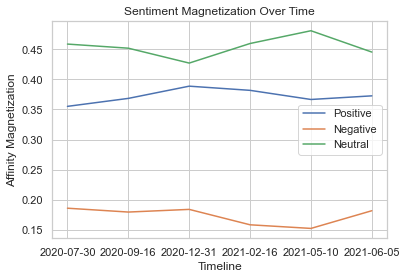

In [7]:
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.plot(myVis['positive'], label = "Positive")
plt.plot(myVis['negative'], label = "Negative")
plt.plot(myVis['neutral'], label = "Neutral")
plt.title('Sentiment Magnetization Over Time')
plt.xlabel('Timeline')
plt.ylabel('Affinity Magnetization')
plt.legend()
plt.show()

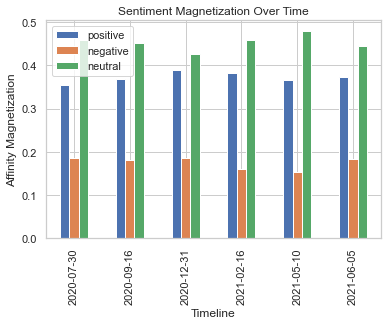

In [8]:
ax= myVis.plot.bar()
plt.title('Sentiment Magnetization Over Time')
plt.xlabel('Timeline')
plt.ylabel('Affinity Magnetization')
plt.legend()
plt.show()

### Data comparison fo Manual Polarization vs Automated Polarization

In [9]:
dataComparison

,polarization,manualRating
0,0.000,0.0
1,-0.300,-0.3
2,-0.200,-0.5
3,0.000,-0.2
4,0.000,0.0
...,...,...
95,0.125,-0.3
96,0.000,-0.3
97,0.400,-0.1
98,0.000,0.2


C:\Users\MITCH-PC\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\MITCH-PC\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


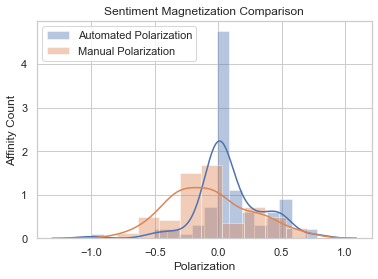

In [10]:
sns.distplot(dataComparison['polarization'], label="Automated Polarization")
sns.distplot(dataComparison['manualRating'], label="Manual Polarization")
plt.title('Sentiment Magnetization Comparison')
plt.xlabel('Polarization')
plt.ylabel('Affinity Count')
plt.legend()
plt.show()

In [11]:
maskSynonyms = ['mask','ffp2']
values = []
maskPolarization = df[df.text.str.contains('mask',case=False)].polarization
maskPolarization1 = df[df.text.str.contains('ffp2',case=False)].polarization
mps = [maskPolarization, maskPolarization1]
maskPolarizationFinal = pd.concat(mps)
maskPolarizationFinal.mean(axis=0)

0.05511019557653136

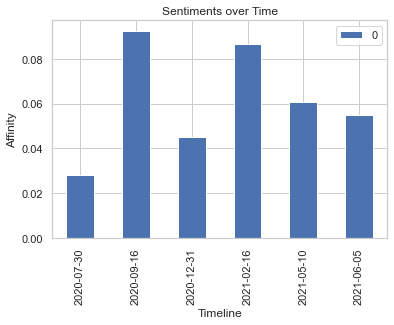

In [12]:
mpsFrame.plot.bar()
plt.title('Sentiments over Time')
plt.xlabel('Timeline')
plt.ylabel('Affinity')
plt.show()

People were happiest about the mask in February with 0.092550% affinity, but there is not a very large difference in general about the opinion

| Date | Affinity % |
| --- | --- |
| 2020-07-30 | 0.027874 |
| 2020-09-16 | 0.092550 |
| 2020-12-31 | 0.044842 |
| 2021-02-16 | 0.086701 |
| 2021-05-10 | 0.060529 |
| 2021-06-05 | 0.054906 |

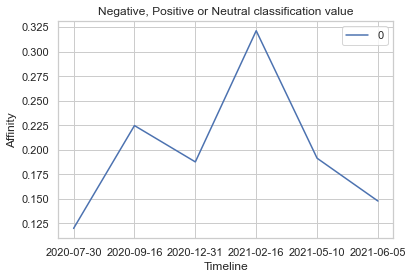

In [13]:
ax2= tMagFrame.plot()
plt.title('Negative, Positive or Neutral classification value')
plt.xlabel('Timeline')
plt.ylabel('Affinity')
plt.show()

## Wordcloud Visualization

A Wordcloud visualization based on the "Mask" filter from the dataset

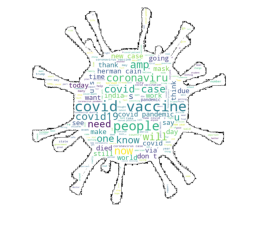

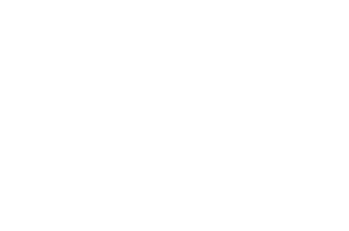

In [14]:
generateWordcloudData(df)